# Group 22 - Random Forest & Decision Tree - Classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools

from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, mean_squared_error
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from urllib.request import urlopen
from scipy import stats
from sklearn import tree

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
#import pydotplus

# 1.0 Import Data

In [2]:
UCI_data_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

In [3]:
names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

'''
Dataset focuses on distinguishing presence of heart diease (0 - absent, 1-4)
cp = chest pain type 
-- Value 1: typical angina 
-- Value 2: atypical angina 
-- Value 3: non-anginal pain 
-- Value 4: asymptomatic 
trestbps - resting blood pressure (in mm Hg on admission)
chol - serum cholesterol in mg/dl
fbs - fasting blood sugar
restecg - resting electrocardiographic results
-- Value 0: normal 
-- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) 
-- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria 
thalach - max heart rate achieved
exang - excercise induced angina (1=yes; 0 = no)
oldpeak = ST depression induced by excerise relative to rest
slope = slope of peak excerise ST segment
ca - number of major vessles colored by fluoroscopy
thal - 3 is normal, 6 = fixed defect, 7 reversible defect
num = presence of heart disease in patient (integer valued from 0 to 4)

'''

In [4]:
heart_disease = pd.read_csv(urlopen(UCI_data_URL), names=names)
heart_disease.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


In [5]:
for parameter in heart_disease:
    print(parameter,':', heart_disease[parameter].dtypes,  ',', heart_disease[parameter].hasnans, ',', heart_disease[parameter].isna().sum())

age : float64 , False , 0
sex : float64 , False , 0
cp : float64 , False , 0
trestbps : float64 , False , 0
chol : float64 , False , 0
fbs : float64 , False , 0
restecg : float64 , False , 0
thalach : float64 , False , 0
exang : float64 , False , 0
oldpeak : float64 , False , 0
slope : float64 , False , 0
ca : object , False , 0
thal : object , False , 0
num : int64 , False , 0


In [6]:
# Clean up str data in float columns
new_ca = []
for val in heart_disease['ca'].tolist():
    if val=='?':
        new_ca.append(val)
    else:
        new_ca.append(float(val))
new_thal = []
for val in heart_disease['thal'].tolist():
    if val=='?':
        new_thal.append(val)
    else:
        new_thal.append(float(val))

In [7]:
# Create new columns for numeric data
heart_disease['num_ca'] = new_ca
heart_disease['num_thal'] = new_thal

In [8]:
# Fill missing data with the column mean
print(heart_disease[heart_disease['num_ca']!='?']['num_ca'].mean())
print(heart_disease[heart_disease['num_thal']!='?']['num_thal'].mean())

0.6722408026755853
4.73421926910299


In [9]:
heart_disease.loc[heart_disease.num_ca =='?','num_ca'] = 0.6722408026755853

In [10]:
heart_disease.loc[heart_disease.num_thal =='?','num_thal'] = 4.73421926910299

In [11]:
# Insert new columns with purely numeric data
heart_disease['num_ca'] = [float(val) for val in heart_disease['num_ca'].tolist()]
heart_disease['num_thal'] = [float(val) for val in heart_disease['num_thal'].tolist()]

In [12]:
# Sanity check for each column
for parameter in heart_disease:
    print(parameter,':', heart_disease[parameter].dtypes,  ',', heart_disease[parameter].hasnans, ',', heart_disease[parameter].isna().sum())

age : float64 , False , 0
sex : float64 , False , 0
cp : float64 , False , 0
trestbps : float64 , False , 0
chol : float64 , False , 0
fbs : float64 , False , 0
restecg : float64 , False , 0
thalach : float64 , False , 0
exang : float64 , False , 0
oldpeak : float64 , False , 0
slope : float64 , False , 0
ca : object , False , 0
thal : object , False , 0
num : int64 , False , 0
num_ca : float64 , False , 0
num_thal : float64 , False , 0


In [13]:
# drop original mixed type columns
heart_disease = heart_disease.drop(columns = ['ca','thal'])

# Consolidate output into binary classes
heart_disease.loc[heart_disease.num !=0,'num'] = 1

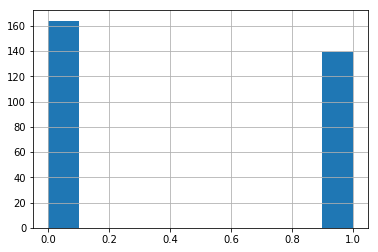

In [14]:
# Check class distribution
heart_disease['num'].hist()

# 2.0 Split Data into Training and Test

In [15]:
# Define features and classes
X = heart_disease.drop('num', axis=1)
y = heart_disease['num']

In [16]:
# Split to training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30,random_state = 101)

In [17]:
# Define functions that will be used for all models

def bias(y_predict,y):
    y_predict = np.array(y_predict)
    y = np.array(y)
    return np.mean(np.power((y_predict-y),2))

def variance(y_predict,y):
    y_predict = np.array(y_predict)
    return np.var(y_predict)

# from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,Fontsize = 12):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=Fontsize)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=Fontsize)
    plt.yticks(tick_marks, classes,fontsize=Fontsize)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),fontsize=Fontsize,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label',fontsize=Fontsize)
    plt.xlabel('Predicted label',fontsize=Fontsize)
    plt.tight_layout()

# 3.0 Decision Tree Classifier

### Optimize Model using Grid Search

In [18]:
# Create instance of a DecisionTreeClassifier
fit_dt = DecisionTreeClassifier(random_state=42)
fit_dt

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [19]:
# Perform gridsearch to determine optimal parameters
# Grid search
param_dist = {
              'max_depth': [2, 3, 4, 8, 10, 20],
              'max_features': ['sqrt', 'log2'],   
              "min_samples_leaf" : [2, 4, 8, 10, 12, 14],
              'criterion': ['gini', 'entropy']
}

In [20]:
cv_dt = GridSearchCV(fit_dt, cv = 5,
                      param_grid=param_dist,
                      n_jobs = 3)
cv_dt.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'max_depth': [2, 3, 4, 8, 10, 20], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [2, 4, 8, 10, 12, 14], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [21]:
print(cv_dt.best_params_)

{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 10}


In [22]:
fit_dt.set_params(criterion = 'entropy', 
                 max_depth = 4,
                 max_features = 'sqrt', 
                 min_samples_leaf = 10)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [23]:
fit_dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [24]:
print('Accuracy of decision tree classifier on Train set: {:.3f}'.format(fit_dt.score(X_train, y_train)))

Accuracy of decision tree classifier on Train set: 0.802


In [25]:
print('Accuracy of decision tree classifier on Test set: {:.3f}'.format(fit_dt.score(X_test, y_test)))

Accuracy of decision tree classifier on Test set: 0.747


In [26]:
y_train_predict = fit_dt.predict(X_train)
y_test_predict = fit_dt.predict(X_test)

Normalized confusion matrix


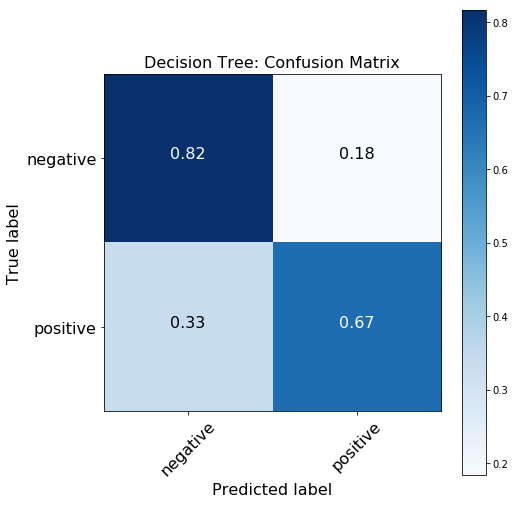

In [27]:
# vizualise confusion matrix
cm_DT = confusion_matrix(y_test,y_test_predict)
plt.figure(figsize=(7.5,7.5))
plot_confusion_matrix(cm_DT,['negative','positive'],title='Decision Tree: Confusion Matrix',normalize=True,Fontsize=16)

In [28]:
scores_DT_gridsearch_classifier = cross_val_score(fit_dt, X, y, cv = 5)
ave_score_DT_gridsearch_classifier = np.mean(scores_DT_gridsearch_classifier)*100
print('The average score using CV is %.2f%%' % ave_score_DT_gridsearch_classifier)

The average score using CV is 72.30%


## Decision Tree: Max_depth tuning

min_samples_leaf is left as default of 1 to avoid interference.

In [29]:
max_depth_DT_classification = np.arange(1,25)

bias_DT_classification = []
var_DT_classification = []
err_DT_classification = []

err_DT_classification_list_test = []
err_DT_classification_list_training = []
err_tot_DT_classification_list = []

cv_error_DT_classification = []

score_DT_classification_ls_test = []
score_DT_classification_ls_training = []

model_DT_Classifier = DecisionTreeClassifier(random_state=42)
model_DT_Classifier.set_params(criterion = 'gini', 
                 max_depth = 4,
                 max_features = 'sqrt')

for entry in max_depth_DT_classification:
    model_DT_Classifier.set_params(max_depth = entry)
    model_DT_Classifier.fit(X_train, y_train)
    predicted_y_DT_classifier_test = model_DT_Classifier.predict(X_test)
    predicted_y_DT_classifier_train = model_DT_Classifier.predict(X_train)
    bias_DT_classification.append(bias(predicted_y_DT_classifier_test,y_test))
    var_DT_classification.append(variance(predicted_y_DT_classifier_test,y_test))
    err_DT_classification.append(bias(predicted_y_DT_classifier_test,y_test)+variance(predicted_y_DT_classifier_test,y_test))
    
    err_DT_test_variable =mean_squared_error(y_test,predicted_y_DT_classifier_test)
    err_DT_training_variable = mean_squared_error(y_train, predicted_y_DT_classifier_train)
    err_DT_tot_variable = err_DT_test_variable + err_DT_training_variable
    err_DT_classification_list_test.append(err_DT_test_variable)
    err_DT_classification_list_training.append(err_DT_training_variable)
    err_tot_DT_classification_list.append(err_DT_tot_variable)
     # average test accuracy
    cv_error_DT_classification.append(np.mean(cross_val_score(model_DT_Classifier, X, y, cv = 5)))
    
    score_DT_classification_ls_test.append(model_DT_Classifier.score(X_test, y_test))
    score_DT_classification_ls_training.append(model_DT_Classifier.score(X_train, y_train))

#### Plot plot bias and variance estimated on the test set

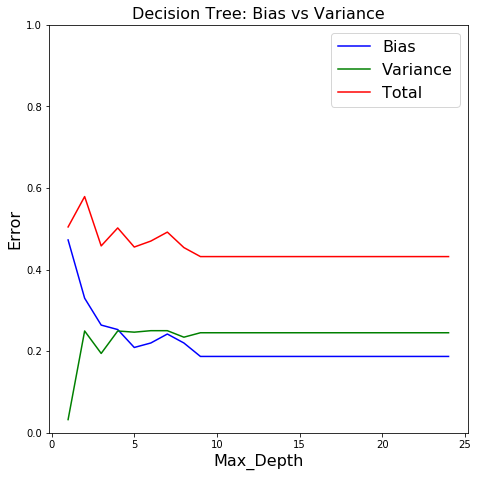

In [30]:
plt.figure(figsize=(7.5,7.5))
plt.plot(max_depth_DT_classification, bias_DT_classification,color='b')
plt.plot(max_depth_DT_classification, var_DT_classification,color='g')
plt.plot(max_depth_DT_classification, err_DT_classification,color='r')
plt.legend(['Bias', 'Variance', 'Total'], loc='upper right',fontsize=16)
plt.title('Decision Tree: Bias vs Variance',fontsize=16)
plt.ylabel('Error',fontsize=16)
plt.xlabel('Max_Depth',fontsize=16)
plt.ylim(0,1)
plt.show()

#### Plot accuracy score to compare training performace with test performance

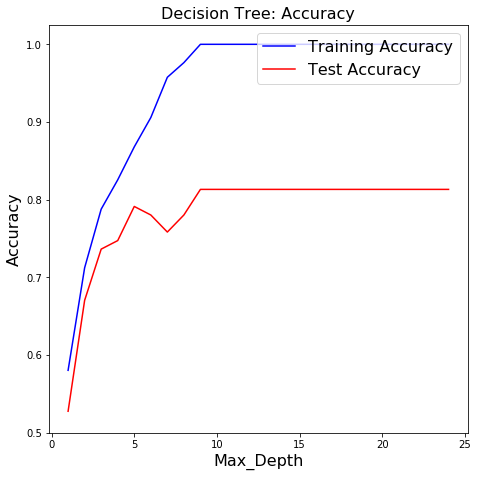

In [31]:
plt.figure(figsize=(7.5,7.5))
plt.plot(max_depth_DT_classification, score_DT_classification_ls_training,color='b')
plt.plot(max_depth_DT_classification, score_DT_classification_ls_test,color='r')
plt.legend(['Training Accuracy', 'Test Accuracy'], loc='upper right',fontsize=16)
plt.title('Decision Tree: Accuracy',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.xlabel('Max_Depth',fontsize=16)
plt.ylim(0.5,1.025)
plt.show()

#### An alternative way to gauge the bias and variance of a model is to minimise the combined error on testing predictions and training predictions. 

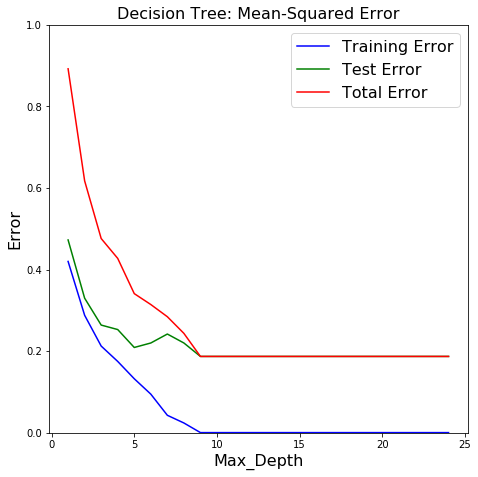

In [32]:
# Plot test error and training error with respect to depth of the tree
plt.figure(figsize=(7.5,7.5))
plt.plot(max_depth_DT_classification, err_DT_classification_list_training,color = 'b')
plt.plot(max_depth_DT_classification, err_DT_classification_list_test,color = 'g')
plt.plot(max_depth_DT_classification, err_tot_DT_classification_list,color = 'r')
plt.legend(['Training Error', 'Test Error', 'Total Error'], loc='upper right',fontsize = 16)
plt.title('Decision Tree: Mean-Squared Error',fontsize = 16)
plt.ylabel('Error',fontsize = 16)
plt.xlabel('Max_Depth',fontsize = 16)
plt.ylim(0,1)
plt.show()

#### Cross validation gives a better estimate of test accuracy but we lose information on training accuracy

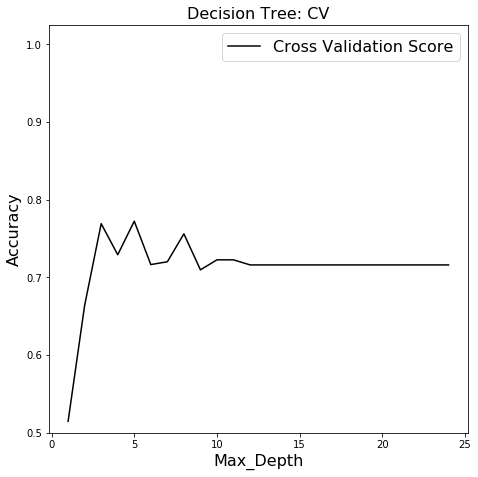

In [33]:
plt.figure(figsize=(7.5,7.5))
plt.plot(max_depth_DT_classification, cv_error_DT_classification,color='k')
plt.legend(['Cross Validation Score'], loc='upper right',fontsize=16)
plt.title('Decision Tree: CV',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.xlabel('Max_Depth',fontsize=16)
plt.ylim(0.5,1.025)
plt.show()

In [34]:
class_names=heart_disease.num.unique()
class_names

array([0, 1])

In [35]:
class_names=heart_disease.num.unique()
type(class_names)
import os     

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [36]:
# See powerpoint for the tree vizualization. 
import graphviz 

dot_data = tree.export_graphviz(fit_dt, out_file=None, 
                         feature_names=heart_disease.drop(columns='num').columns,  
                         class_names=['0', '1'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render('dtree_render', view=True)

'dtree_render.pdf'

# 4.0 Random Forest Classifier 

In [37]:
fit_rf = RandomForestClassifier(random_state=42,oob_score = False)

Perform gridsearch to determine optimal parameters


In [38]:
param_dist = {
              "n_estimators" : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
              'max_depth': [2, 3, 4, 8, 10, 20],
              'bootstrap': [True, False],
              'max_features': ['sqrt', 'log2'],   
              "min_samples_leaf" : [2, 4, 8, 10, 12, 14],
              'criterion': ['gini', 'entropy']
}

In [ ]:
cv_rf = GridSearchCV(fit_rf, cv = 5,
                     param_grid=param_dist,
                     n_jobs = -1)
cv_rf.fit(X_train, y_train)

In [ ]:
print(cv_rf.best_params_)

In [ ]:
# Set to outcome of grid search
fit_rf.set_params(bootstrap = True,
                 criterion = 'gini', 
                 max_depth = 2,
                 max_features = 'sqrt', 
                 min_samples_leaf = 2,
                 n_estimators=10,
                 oob_score = True)

Train Model

In [44]:
fit_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [45]:
print('Accuracy of random forest classifier on Train set: {:.3f}'.format(fit_rf.score(X_train, y_train)))

Accuracy of random forest classifier on Train set: 0.873


In [46]:
print('Accuracy of random forest classifier on Test set: {:.3f}'.format(fit_rf.score(X_test, y_test)))

Accuracy of random forest classifier on Test set: 0.791


In [47]:
y_train_predict = fit_rf.predict(X_train)

y_test_predict = fit_rf.predict(X_test)

Normalized confusion matrix


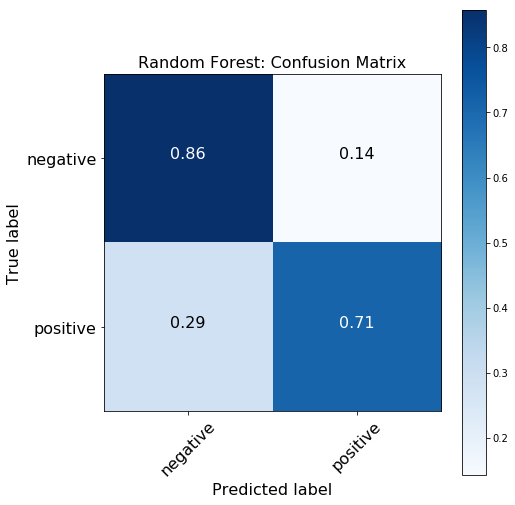

In [48]:
cm_RF = confusion_matrix(y_test,y_test_predict)
plt.figure(figsize=(7.5,7.5))
plot_confusion_matrix(cm_RF,['negative','positive'],title='Random Forest: Confusion Matrix',normalize=True,Fontsize=16)

Comppare to a decision tree using the same parameters

Normalized confusion matrix


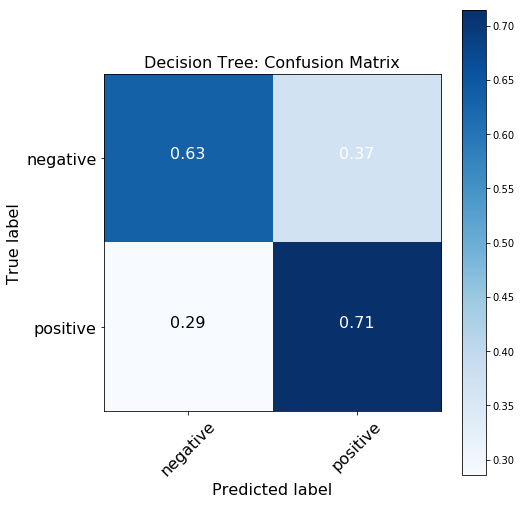

In [50]:
fit_dt.set_params(criterion = 'gini', 
                 max_depth = 2,
                 max_features = 'sqrt', 
                 min_samples_leaf = 2)
fit_dt.fit(X_train, y_train)
y_train_predict = fit_dt.predict(X_train)
y_test_predict = fit_dt.predict(X_test)
# vizualise confusion matrix
cm_DT = confusion_matrix(y_test,y_test_predict)
plt.figure(figsize=(7.5,7.5))
plot_confusion_matrix(cm_DT,['negative','positive'],title='Decision Tree: Confusion Matrix',normalize=True,Fontsize=16)

### Cross Validation vs OOB

In [51]:
ave_oob_score_RF_best_classifier = (fit_rf.oob_score_)*100
print('The average score using Out-of-Bag estimate is %.2f%%' % ave_oob_score_RF_best_classifier)

The average score using Out-of-Bag estimate is 78.30%


In [52]:
scores_RF_best_classifier = cross_val_score(fit_rf, X, y, cv = 5)
ave_cv_score_RF_best_classifier = np.mean(scores_RF_best_classifier)*100
print('The average score using CV is %.2f%%' % ave_cv_score_RF_best_classifier)

The average score using CV is 81.84%


### Random Forest: Sample Max_depth tuning

min_samples_leaf is left as default of 1 to avoid interference.

In [53]:
# Change hyperparamters(max_depth) to see effect on bias and variance
max_depth_RF_classification = np.arange(2,25)
bias_RF_classification = []
var_RF_classification = []
err_RF_classification = []

err_RF_classification_list_test = []
err_RF_classification_list_training = []
err_tot_RF_classification_list = []

cv_error_RF_classification = []
oob_error_RF_classification = []

score_RF_classification_ls_test = []
score_RF_classification_ls_training = []

model_RF_Classifier = RandomForestClassifier(random_state=42,oob_score = True)
model_RF_Classifier.set_params(bootstrap = True,
                 criterion = 'entropy', 
                 max_depth = 4,
                 max_features = 'sqrt',
                 oob_score = True,
                 n_estimators=90)

for entry in max_depth_RF_classification:
    #Alter max_depth for each run
    model_RF_Classifier.set_params(max_depth= entry)
    model_RF_Classifier.fit(X_train, y_train)
    predicted_y_RF_classifier_test = model_RF_Classifier.predict(X_test)
    predicted_y_RF_classifier_training = model_RF_Classifier.predict(X_train)
    
    bias_RF_classification.append(bias(predicted_y_RF_classifier_test,y_test))
    var_RF_classification.append(variance(predicted_y_RF_classifier_test,y_test))
    err_RF_classification.append(bias(predicted_y_RF_classifier_test,y_test)+variance(predicted_y_RF_classifier_test,y_test))
    
    err_RF_test_variable =mean_squared_error(y_test,predicted_y_RF_classifier_test)
    err_RF_training_variable = mean_squared_error(y_train, predicted_y_RF_classifier_training)
    err_RF_tot_variable = err_RF_test_variable + err_RF_training_variable
    err_RF_classification_list_test.append(err_RF_test_variable)
    err_RF_classification_list_training.append(err_RF_training_variable)
    err_tot_RF_classification_list.append(err_RF_tot_variable)
    
    cv_error_RF_classification.append(np.mean(cross_val_score(model_RF_Classifier, X, y, cv = 5)))
    oob_error_RF_classification.append(model_RF_Classifier.oob_score_)
    
    score_RF_classification_ls_test.append(model_RF_Classifier.score(X_test, y_test))
    score_RF_classification_ls_training.append(model_RF_Classifier.score(X_train, y_train))

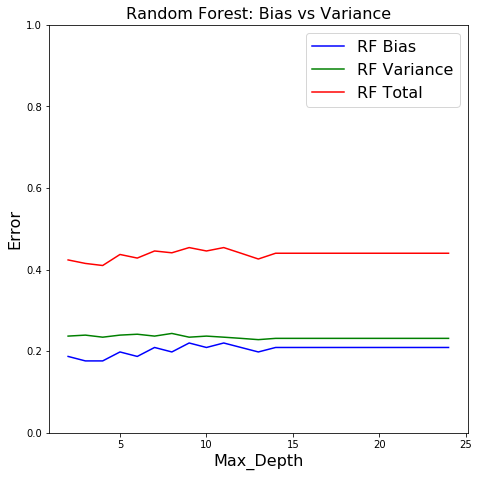

In [50]:
plt.figure(figsize=(7.5,7.5))
plt.plot(max_depth_RF_classification, bias_RF_classification,color='b')
plt.plot(max_depth_RF_classification, var_RF_classification,color='g')
plt.plot(max_depth_RF_classification, err_RF_classification,color='r')

plt.legend(['RF Bias', 'RF Variance', 'RF Total','DT Bias', 'DT Variance', 'DT Total'], loc='upper right',fontsize=16)
plt.title('Random Forest: Bias vs Variance',fontsize=16)
plt.ylabel('Error',fontsize=16)
plt.xlabel('Max_Depth',fontsize=16)
plt.ylim(0,1)
plt.show()

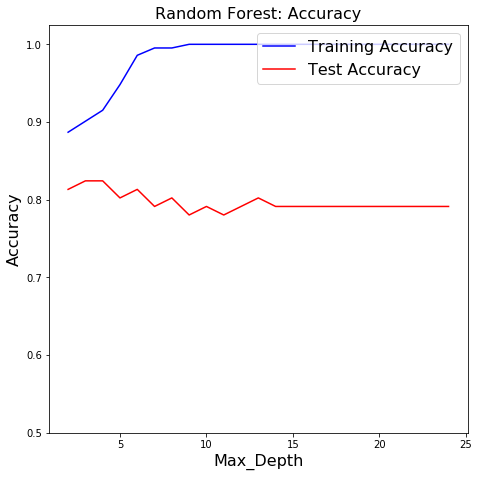

In [54]:
plt.figure(figsize=(7.5,7.5))
plt.plot(max_depth_RF_classification, score_RF_classification_ls_training,color='b')
plt.plot(max_depth_RF_classification, score_RF_classification_ls_test,color='r')
plt.legend(['Training Accuracy', 'Test Accuracy'], loc='upper right',fontsize=16)
plt.title('Random Forest: Accuracy',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.xlabel('Max_Depth',fontsize=16)
plt.ylim(0.5,1.025)
plt.show()

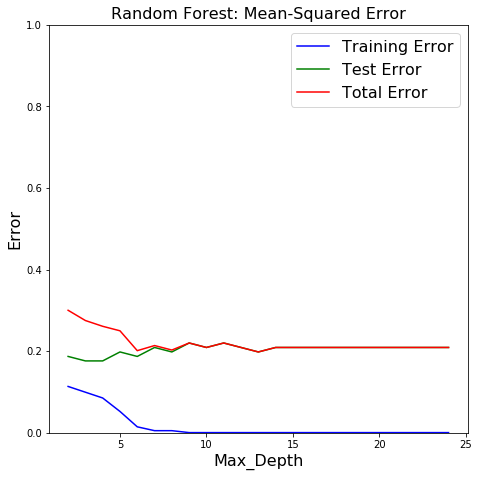

In [55]:
plt.figure(figsize=(7.5,7.5))
plt.plot(max_depth_RF_classification, err_RF_classification_list_training,color = 'b')
plt.plot(max_depth_RF_classification, err_RF_classification_list_test,color = 'g')
plt.plot(max_depth_RF_classification, err_tot_RF_classification_list,color = 'r')
plt.legend(['Training Error', 'Test Error', 'Total Error'], loc='upper right',fontsize = 16)
plt.title('Random Forest: Mean-Squared Error',fontsize = 16)
plt.ylabel('Error',fontsize = 16)
plt.xlabel('Max_Depth',fontsize = 16)
plt.ylim(0,1)
plt.show()

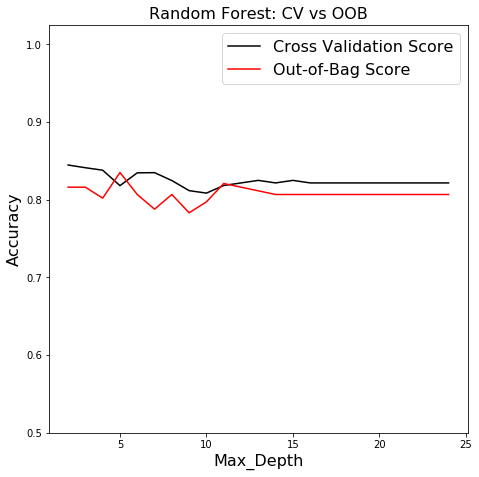

In [56]:
plt.figure(figsize=(7.5,7.5))
plt.plot(max_depth_RF_classification, cv_error_RF_classification,color='k')
plt.plot(max_depth_RF_classification, oob_error_RF_classification,color='r')
plt.legend(['Cross Validation Score', 'Out-of-Bag Score'], loc='upper right',fontsize=16)
plt.title('Random Forest: CV vs OOB',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.xlabel('Max_Depth',fontsize=16)
plt.ylim(0.5,1.025)
plt.show()

### N_estimator tuning

In [57]:
# Change hyperparamters(n_estimators) to see effect on bias and variance
n_estimators_RF_classification = np.arange(10,100)
bias_RF_classification = []
var_RF_classification = []
err_RF_classification = []

err_RF_classification_list_test = []
err_RF_classification_list_training = []
err_tot_RF_classification_list = []

cv_error_RF_classification = []
oob_error_RF_classification = []

score_RF_classification_ls_test = []
score_RF_classification_ls_training = []

model_RF_Classifier = RandomForestClassifier(random_state=42,oob_score = True)
model_RF_Classifier.set_params(bootstrap = True,
                 criterion = 'entropy', 
                 max_depth = 4,
                 max_features = 'sqrt',
                 min_samples_leaf = 2,
                 oob_score = True,
                 n_estimators=90)

for entry in n_estimators_RF_classification:
    #Alter max_depth for each run
    model_RF_Classifier.set_params(n_estimators= entry)
    model_RF_Classifier.fit(X_train, y_train)
    predicted_y_RF_classifier_test = model_RF_Classifier.predict(X_test)
    predicted_y_RF_classifier_training = model_RF_Classifier.predict(X_train)
    
    bias_RF_classification.append(bias(predicted_y_RF_classifier_test,y_test))
    var_RF_classification.append(variance(predicted_y_RF_classifier_test,y_test))
    err_RF_classification.append(bias(predicted_y_RF_classifier_test,y_test)+variance(predicted_y_RF_classifier_test,y_test))
    
    err_RF_test_variable =mean_squared_error(y_test,predicted_y_RF_classifier_test)
    err_RF_training_variable = mean_squared_error(y_train, predicted_y_RF_classifier_training)
    err_RF_tot_variable = err_RF_test_variable + err_RF_training_variable
    err_RF_classification_list_test.append(err_RF_test_variable)
    err_RF_classification_list_training.append(err_RF_training_variable)
    err_tot_RF_classification_list.append(err_RF_tot_variable)
    
    cv_error_RF_classification.append(np.mean(cross_val_score(model_RF_Classifier, X, y, cv = 5)))
    oob_error_RF_classification.append(model_RF_Classifier.oob_score_)
    
    score_RF_classification_ls_test.append(model_RF_Classifier.score(X_test, y_test))
    score_RF_classification_ls_training.append(model_RF_Classifier.score(X_train, y_train))

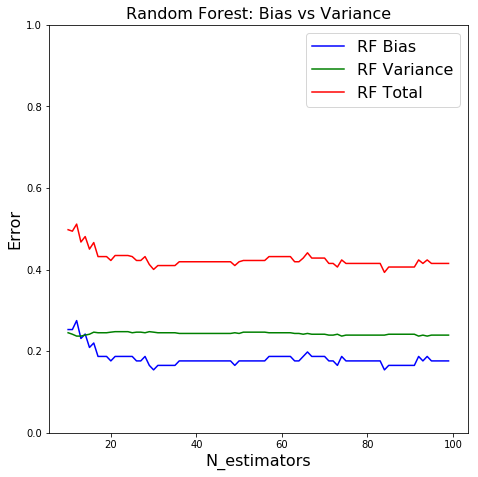

In [58]:
plt.figure(figsize=(7.5,7.5))
plt.plot(n_estimators_RF_classification, bias_RF_classification,color='b')
plt.plot(n_estimators_RF_classification, var_RF_classification,color='g')
plt.plot(n_estimators_RF_classification, err_RF_classification,color='r')

plt.legend(['RF Bias', 'RF Variance', 'RF Total','DT Bias', 'DT Variance', 'DT Total'], loc='upper right',fontsize=16)
plt.title('Random Forest: Bias vs Variance',fontsize=16)
plt.ylabel('Error',fontsize=16)
plt.xlabel('N_estimators',fontsize=16)
plt.ylim(0,1)
plt.show()

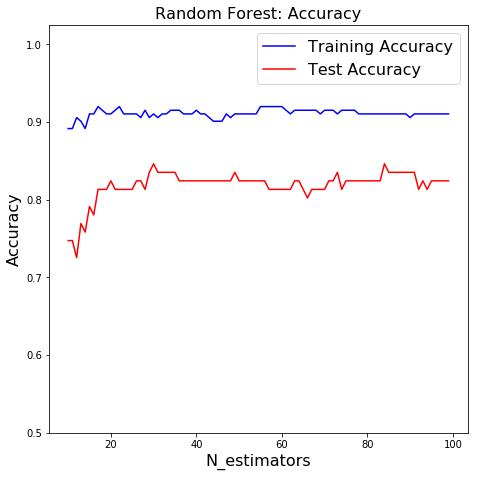

In [59]:
plt.figure(figsize=(7.5,7.5))
plt.plot(n_estimators_RF_classification, score_RF_classification_ls_training,color='b')
plt.plot(n_estimators_RF_classification, score_RF_classification_ls_test,color='r')
plt.legend(['Training Accuracy', 'Test Accuracy'], loc='upper right',fontsize=16)
plt.title('Random Forest: Accuracy',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.xlabel('N_estimators',fontsize=16)
plt.ylim(0.5,1.025)
plt.show()

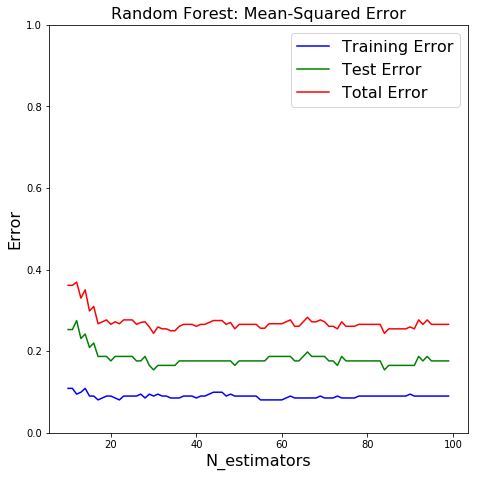

In [60]:
plt.figure(figsize=(7.5,7.5))
plt.plot(n_estimators_RF_classification, err_RF_classification_list_training,color = 'b')
plt.plot(n_estimators_RF_classification, err_RF_classification_list_test,color = 'g')
plt.plot(n_estimators_RF_classification, err_tot_RF_classification_list,color = 'r')
plt.legend(['Training Error', 'Test Error', 'Total Error'], loc='upper right',fontsize = 16)
plt.title('Random Forest: Mean-Squared Error',fontsize = 16)
plt.ylabel('Error',fontsize = 16)
plt.xlabel('N_estimators',fontsize = 16)
plt.ylim(0,1)
plt.show()

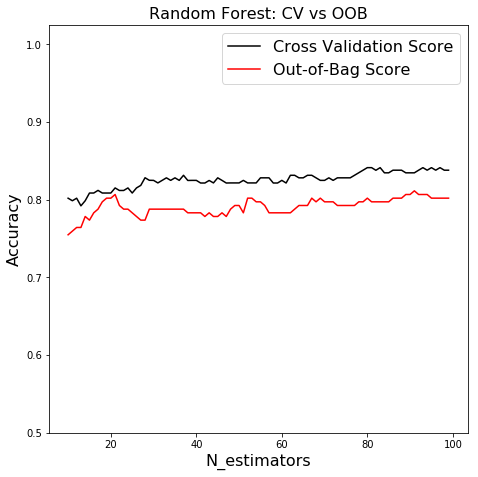

In [61]:
plt.figure(figsize=(7.5,7.5))
plt.plot(n_estimators_RF_classification, cv_error_RF_classification,color='k')
plt.plot(n_estimators_RF_classification, oob_error_RF_classification,color='r')
plt.legend(['Cross Validation Score', 'Out-of-Bag Score'], loc='upper right',fontsize=16)
plt.title('Random Forest: CV vs OOB',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.xlabel('N_estimators',fontsize=16)
plt.ylim(0.5,1.025)
plt.show()

# Variable Importance

One downside to using ensemble methods with decision trees is that you lose the interpretability a single tree gives. A single tree can outline for us important node splits, as well as variables that were important at each split.

Fortunately, ensemble methods that rely on CART models use a metric to evaluate the homogeneity of splits (i.e. gini or entropy). Thus, when creating ensembles, these metrics can be utilized to give insight into the important variables used in the training of the model. 

In [62]:
importances_rf = fit_rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

In [63]:
def variable_importance(importance, indices):
    """
    Purpose:
    ----------
    Prints dependent variable names ordered from largest to smallest
    based on gini or information gain for CART model.

    Parameters:
    ----------
    names:      Name of columns included in model
    importance: Array returned from feature_importances_ for CART
                   models organized by dataframe index
    indices:    Organized index of dataframe from largest to smallest
                   based on feature_importances_

    Returns:
    ----------
    Print statement outputting variable importance in descending order
    """
    print("Feature ranking:")

    for f in range(len(names_index)):
        i = f
        print("%d. The feature '%s' \
has a Mean Decrease in Gini of %f" % (f + 1,
                                         names_index[indices[i]],
                                         importance[indices[f]]))

In [64]:
names_index = names[:-1]
names_index
variable_importance(importances_rf, indices_rf)

Feature ranking:
1. The feature 'thal' has a Mean Decrease in Gini of 0.251328
2. The feature 'thalach' has a Mean Decrease in Gini of 0.167241
3. The feature 'cp' has a Mean Decrease in Gini of 0.164209
4. The feature 'exang' has a Mean Decrease in Gini of 0.151303
5. The feature 'ca' has a Mean Decrease in Gini of 0.090431
6. The feature 'chol' has a Mean Decrease in Gini of 0.054122
7. The feature 'oldpeak' has a Mean Decrease in Gini of 0.053280
8. The feature 'slope' has a Mean Decrease in Gini of 0.036142
9. The feature 'trestbps' has a Mean Decrease in Gini of 0.031944
10. The feature 'restecg' has a Mean Decrease in Gini of 0.000000
11. The feature 'fbs' has a Mean Decrease in Gini of 0.000000
12. The feature 'sex' has a Mean Decrease in Gini of 0.000000
13. The feature 'age' has a Mean Decrease in Gini of 0.000000


In [65]:
names_index

['age',
 'sex',
 'cp',
 'trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalach',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal']

In [66]:
def variable_importance_plot(importance, indices,Fontsize = 16):
    """
    Purpose
    ----------
    Prints bar chart detailing variable importance for CART model
    NOTE: feature_space list was created because the bar chart
    was transposed and index would be in incorrect order.

    Parameters
    ----------
    importance_desc: Array returned from feature_importances_ for CART
                    models organized in descending order

    indices: Organized index of dataframe from largest to smallest
                    based on feature_importances_
    Returns:
    ----------
    Returns variable importance plot in descending order
    """
    index = np.arange(len(names_index))

    importance_desc = sorted(importance)
    feature_space = []
    for i in range(12, -1, -1):
        feature_space.append(names_index[indices[i]])

    fig, ax = plt.subplots(figsize=(8, 8))

    plt.title('Feature importances for Random Forest Model\
    \nHeart Disease',fontsize = Fontsize)
    plt.barh(index,
         importance_desc,
         align="center",
         color = '#875FDB')
    plt.yticks(index,
           feature_space,fontsize = Fontsize)

    plt.xlim(0, max(importance_desc))
    plt.xlabel('Mean Decrease in Gini',fontsize = Fontsize)
    plt.ylabel('Feature',fontsize = Fontsize)

    plt.show()
    plt.close()

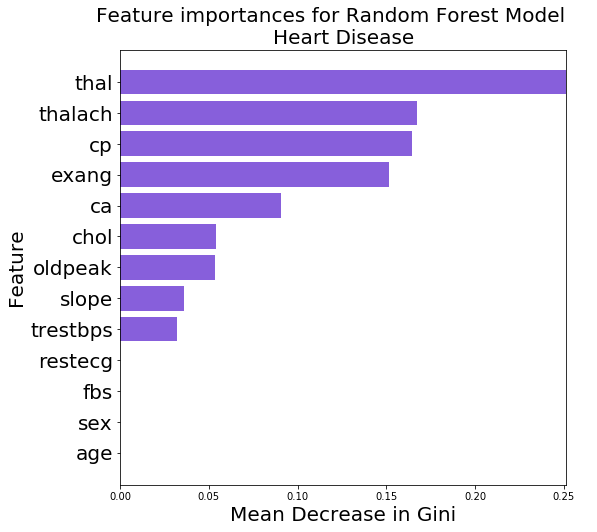

In [67]:
variable_importance_plot(importances_rf, indices_rf, Fontsize = 20)

# ROC Curve

Area under the ROC curve: 0.673469


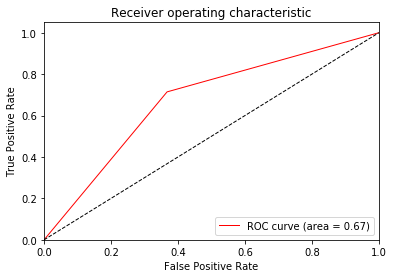

In [68]:
# ROC curve - plot True Positive Rate against False Positive Rate fr random forest
fpr, tpr, thresholds = roc_curve(y_test, y_test_predict)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve: %f" % roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='red', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()